In [1]:
using DifferentialEquations
using Plots

Consider the simple reaction:

\begin{align}
    A &\longleftrightarrow B\\
    B &\longleftrightarrow C\\
\end{align}

Both are elementary steps that occur in the liquid phase, and we will consider it in a few different solvent environments.

In [10]:
gammaA(XA, XS, A12A, A21A) = exp.(XS.^2 .*(A12A .+ 2*(A21A - A12A)*XA))
gammaB(XB, XS, A12B, A21B) = exp.(XS.^2 .*(A12B .+ 2*(A21B - A12B)*XB))
gammaC(XC, XS, A12C, A21C) = exp.(XS.^2 .*(A12C .+ 2*(A21C - A12C)*XC))

gammaTS1(XTS1, XS, A12TS1, A21TS1) = exp.(XS.^2 .*(A12TS1 .+ 2*(A21TS1 - A12TS1)*XTS1))
gammaTS2(XTS2, XS, A12TS2, A21TS2) = exp.(XS.^2 .*(A12TS2 .+ 2*(A21TS2 - A12TS2)*XTS2))

z1(XA, XB, XS, A12A, A21A, A12B, A21B) = 1/K10*gammaB(XB, XS, A12B, A21B)./gammaA(XA, XS, A12A, A21A).*XB./XA
z2(XB, XC, XS, A12B, A21B, A12C, A21C) = 1/K20*gammaC(XC, XS, A12C, A21C)./gammaB(XB, XS, A12B, A21B).*XC./XB

rate1(XA, XB, XTS1, XS, A12A, A21A, A12B, A21B, A12TS1, A21TS1) = k10*gammaA(XA, XS, A12A, A21A)./gammaTS1(XTS1, XS, A12TS1, A21TS1).*XA.*(1 .- z1(XA, XB, XS, A12A, A21A, A12B, A21B))
rate2(XB, XC, XTS2, XS, A12B, A21B, A12C, A21C, A12TS2, A21TS2) = k20*gammaB(XB, XS, A12B, A21B)./gammaTS2(XTS2, XS, A12TS2, A21TS2).*XB.*(1 .- z2(XB, XC, XS, A12B, A21B, A12C, A21C))

rate2 (generic function with 1 method)

In [34]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, k20, K10, K20, V, NS = PAR
    
    NA = u[:,1]
    NB = u[:,2]
    NC = u[:,3]
    NT = NA + NB + NC .+ NS
    
    XA   = NA./NT
    XB   = NB./NT
    XC   = NC./NT
    XTS1 = XA
    XTS2 = XB
    XS   = NS./NT
    
    #For A in solvent
    A12A = MAR[1]
    A21A = MAR[2]

    #For B in solvent
    A12B = MAR[3]
    A21B = MAR[4]
    
    #For C in solvent
    A12C = MAR[5]
    A21C = MAR[6]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[7]
    A21TS1 = MAR[8]
    
    #For Transition State 2 in solvent
    A12TS2 = MAR[9]
    A21TS2 = MAR[10]
    
    gammaA = exp.(XS.^2 .*(A12A .+ 2*(A21A - A12A)*XA))
    gammaB = exp.(XS.^2 .*(A12B .+ 2*(A21B - A12B)*XB))
    gammaC = exp.(XS.^2 .*(A12C .+ 2*(A21C - A12C)*XC))

    gammaTS1 = exp.(XS.^2 .*(A12TS1 .+ 2*(A21TS1 - A12TS1)*XTS1))
    gammaTS2 = exp.(XS.^2 .*(A12TS2 .+ 2*(A21TS2 - A12TS2)*XTS2))

    z1 = 1/K10*gammaB./gammaA.*XB./XA
    z2 = 1/K20*gammaC./gammaB.*XC./XB

    z2[isnan.(z2)] .= 0
    
    r1 = k10*gammaA./gammaTS1.*XA.*(1 .- z1).*NT/V
    r2 = k20*gammaB./gammaTS2.*XB.*(1 .- z2).*NT/V    
    
    RA = -r1[1]
    RB =  r1[1] - r2[1]
    RC =          r2[1]
    
    du[1] = RA*V
    du[2] = RB*V
    du[3] = RC*V
    return du, r1, r2, z1, z2
end

batch (generic function with 1 method)

In [47]:
k10  = 1
k20  = 1
K10  = 1
K20  = 1
V    = 1
NTOT = 100
NA0  = 0.1
NB0  = 0.0
NC0  = 0.0
NS   = NTOT - NA0 - NB0 - NC0
var0 = [NA0 NB0 NC0]
span = (0.0, 20.0);

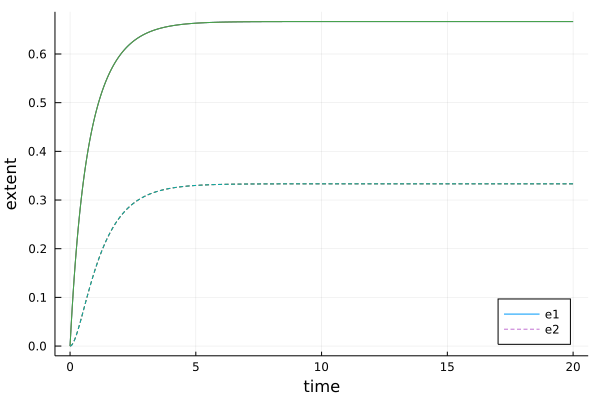

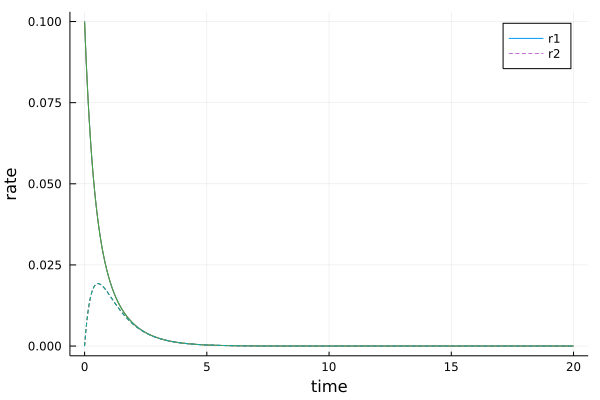

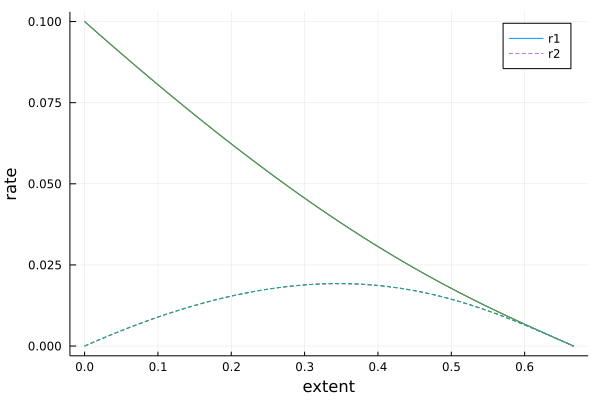

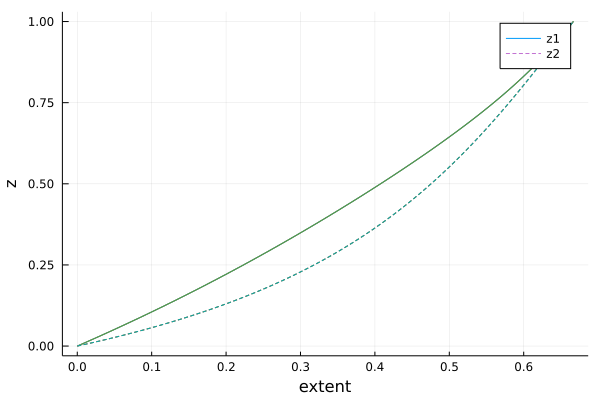

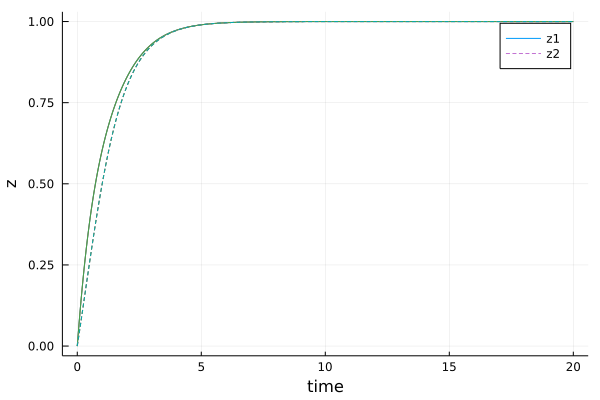

In [62]:
#Solvate transition state relative to reactants
MARSET1 = zeros(10,3)
MARSET1[:,1] = [0.0, 0.0, 0.0, 0.0,  0.0, 0.0,  0.0, 0.0, 0.0, 0.0] #no solvation
MARSET1[:,2] = [0.0, 0.0, 0.0, 0.0,  0.0, 0.0,  0.0, 0.0, 0.0, 0.0] #destabilize TS1
MARSET1[:,3] = [0.0, 0.0, 0.0, 0.0,  0.0, 0.0,  0.0, 0.0, 0.0, 0.0] #stabilize TS1

tfine  = range(0.0, stop = maximum(span), length = 1000)
e1out   = zeros(length(tfine), size(MARSET1, 2))
e2out   = zeros(length(tfine), size(MARSET1, 2))
r1out   = zeros(length(tfine), size(MARSET1, 2))
r2out   = zeros(length(tfine), size(MARSET1, 2))
z1out   = zeros(length(tfine), size(MARSET1, 2))
z2out   = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, k20, K10, K20, V, NS])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-10, reltol = 1e-10)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NC   = solf[3,:]
    NT   = NA + NB + NC .+ NS
    ex1  = (NA0 .- NA)/NA0
    ex2  = (NC)/NA0
    
    dut, rt1, rt2, zt1, zt2 = batch([0., 0., 0.], [NA NB NC], p0, tfine)
    
    e1out[:,i] = ex1
    e2out[:,i] = ex2
    r1out[:,i] = rt1
    r2out[:,i] = rt2
    z1out[:,i] = zt1
    z2out[:,i] = zt2   
end

plt1 = plot(tfine, e1out, xlabel  = "time", ylabel = "extent", labels = ["e1" nothing nothing], legend = :bottomright)
plt1 = plot!(plt1,tfine, e2out, ls = :dash, labels = ["e2" nothing nothing])
plt2 = plot(tfine, r1out, xlabel  = "time", ylabel = "rate", labels = ["r1" nothing nothing], legend = :topright)
plt2 = plot!(tfine, r2out, ls = :dash, labels = ["r2" nothing nothing])
plt3 = plot(e1out, r1out, xlabel  = "extent", ylabel = "rate", labels = ["r1" nothing nothing], legend = :topright)
plt3 = plot!(e1out, r2out, ls = :dash, labels = ["r2" nothing nothing])
plt4 = plot(e1out, z1out, xlabel  = "extent", ylabel = "z", labels = ["z1" nothing nothing], legend = :topright)
plt4 = plot!(e1out, z2out, ls = :dash, labels = ["z2" nothing nothing])
plt5 = plot(tfine, z1out, xlabel  = "time", ylabel = "z", labels = ["z1" nothing nothing], legend = :topright)
plt5 = plot!(tfine, z2out, ls = :dash, labels = ["z2" nothing nothing])

display(plt1)
display(plt2)
display(plt3)
display(plt4)
display(plt5)